# <center> Imágenes y Machine Learning en Python 2020

**Recomendación:**
+ Antes que nada **realice una copia de este archivo y trabaje en ella** (File-> Make a Copy, puede cambiarle el nombre fácilmente). Guárdelo en la misma carpeta de preferencia (si está en Colaboratory lo guarda por defecto en la carpeta Colaboratory del drive, se puede reubicar).

## Inicio y consideraciones
+ Este archivo y todos los de extensión .ipynb se abren con Jupyter Notebook (de Anaconda) o Google Colaboratory y se dividen en bloques.
+ Básicamente: bloques de texto (Markdown) y otros de código (Code, en Python). 
+ Cualquier bloque se ejecuta con shift+enter o utilizando el botón Run.
+ Los bloques se pueden eliminar con el menú Edit. O con los botones correspondientes (cortar, copiar, pegar, desplazar).
+ El archivo se puede ejecutar en el entorno de Windows en la carpeta correspondiente (o desde cualquiera si se ha configurado el path) mediante el comando python en línea de comandos

**En los bloques de texto (Markdown)** :

* Mediante un doble clic en el bloque, posibilito la modificación del mismo.
* Para títulos se usa # y luego del símbolo # se debe dejar un espacio.
* Con varios ## se manejan los subtítulos por niveles y, con esto, el tamaño de la letra.
* Encerrando un texto entre uno o dos asteriscos se consigue texto en cursiva o negrita.

**En los bloques de código (Code)** :
* Si el renglón  empieza con # es comentario, si no, es instrucción.
* En una línea de instrucción, se pueda agregar al final un comentario luego de #.


**shift+enter** para ejecutar cada celda/bloque/Cell (o botón Run), tanto en bloque de textos como de códigos

Una vez más importamos las librerías utilizadas en la anterior notebook y cargamos las librerías e imágenes a trabajar correspondientes.

In [1]:
import tensorflow
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

/home/leandro/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [209]:
import sys
sys.path.insert(1, '/media/leandro/Volumen1TB1/Alt Atlas/Image_analysis')

import src.Upload_images as ui
import src.Filtering as F
import src.Data_extraction as de
import src.Data_processing as dp
import src.plotting_visualization as pv
import src.ROI_manual_selector as rms
from keras import regularizers

## Dataset CIFAR Keras

![TFK](CIFAR.jpg)

## Carga de datos

Cargamos el dataset desde la librería Keras con la siguiente línea de código:

In [50]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [166]:
import os, random

path = '/media/leandro/Volumen1TB1/Alt Atlas/images/Leloir/image05/'
X_train = np.array([ui.readimages_asmatrix(path + 'front/' + x) for x in os.listdir(path + 'front/')[:170]] + [ui.readimages_asmatrix(path + 'back/' + x) for x in os.listdir(path + 'back/')[:244]])
y_train = np.array([0]*170 + [1]* 244)
X_test = np.array([ui.readimages_asmatrix(path + 'front/' + x) for x in os.listdir(path + 'front/')[170:]] + [ui.readimages_asmatrix(path + 'back/' + x) for x in os.listdir(path + 'back/')[244:]])
y_test = np.array([0]*137 + [1]* 170)

In [167]:
len(X_test)

307

Verificamos su formato

In [168]:
type(y_train)

numpy.ndarray

Exploramos las dimensiones del dataset

In [169]:
print(X_train.shape)
print(y_train.shape)

(414, 50, 50, 3)
(414,)


## Exploración de Datos

Verificamos la distribución por clases tanto en los datos de entrenamiento como en los datos de prueba

In [170]:
unicos, cantidad = np.unique(y_train, return_counts = True)

print(f'El dataset posee imágenes de los siguentes números: {unicos}, y a cada número le corresponde la siguente cantidad: {cantidad}')

El dataset posee imágenes de los siguentes números: [0 1], y a cada número le corresponde la siguente cantidad: [170 244]


In [171]:
unicos, cantidad = np.unique(y_test, return_counts = True)

print(f'El dataset posee imágenes de los siguentes números: {unicos}, y a cada número le corresponde la siguente cantidad {cantidad}')

El dataset posee imágenes de los siguentes números: [0 1], y a cada número le corresponde la siguente cantidad [137 170]


Mostramos 10 imágenes al azar con su respectiva etiqueta

La posición de la imagen a mostrar es la 15
La etiqueta de la imagen es: 0


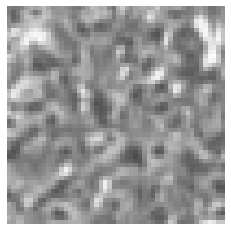

La posición de la imagen a mostrar es la 3
La etiqueta de la imagen es: 0


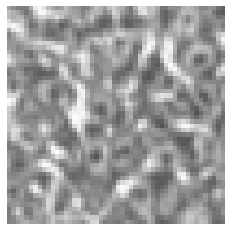

La posición de la imagen a mostrar es la 23
La etiqueta de la imagen es: 0


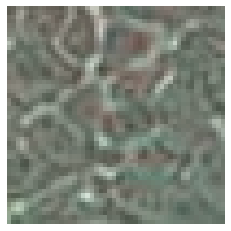

La posición de la imagen a mostrar es la 16
La etiqueta de la imagen es: 0


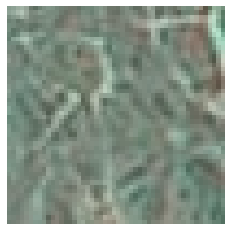

La posición de la imagen a mostrar es la 17
La etiqueta de la imagen es: 0


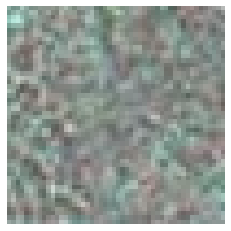

La posición de la imagen a mostrar es la 19
La etiqueta de la imagen es: 0


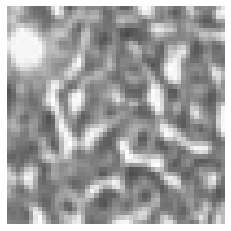

La posición de la imagen a mostrar es la 17
La etiqueta de la imagen es: 0


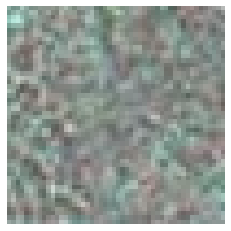

La posición de la imagen a mostrar es la 1
La etiqueta de la imagen es: 0


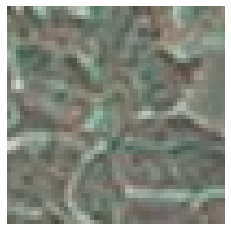

La posición de la imagen a mostrar es la 28
La etiqueta de la imagen es: 0


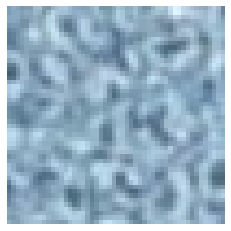

La posición de la imagen a mostrar es la 19
La etiqueta de la imagen es: 0


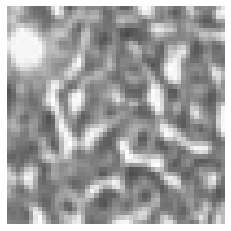

In [172]:
for i in range(10):
    numero = np.random.randint(low = 0, high = 30)
    print(f'La posición de la imagen a mostrar es la {numero}')
    print(f'La etiqueta de la imagen es: {y_train[numero]}')
    plt.imshow(X_train[numero, :, :], cmap = 'gray')
    plt.axis('off')
    plt.show()

## Procesamiento de Datos

Convertimos las etiquetas en formato One - Hot

![TFK](onehot.png)

In [173]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Redes Neuronales Convolucionales

## Definición por capas

Esta vez, empezamos a trabajar con redes neuronales convolucionales, que como dijimos anteriormente son las más indicadas para poder trabajar con imágenes médicas debido a su capacidad de conservar la vecindad entre píxeles y de detección de patrones sin variar durante la traslación. Su utilización es la misma que la de las redes neuronales tradicionales o fully connected puesto que se importan también desde el módulo "layers".

## Capa de Entrada

La entrada se define de la misma manera que en la notebook anterior, con el método "Input", la única salvedad es la manera en la que definimos la dimensión de la red. En este caso, introducimos la imagen como matriz dado que deseamos conservar la vecindad de los píxeles de las mismas.

In [174]:
Imagen_de_entrada = layers.Input(shape = (50, 50, 3))

## Capa de Convolución

Luego de definir las entradas de la red, definimos las capas de convolución. Del módulo "layers" importamos el método "Conv2D". Al igual que las tradicionales, a las redes convolucionales hay que asignarle una función de activación que puedan utilizar para el aprendizaje. Sin embargo, hay que asignar otros parámetros diferentes a las tradicionales:

* filters: La cantidad de filtros que realizarán la operación de convolución en los datos de entrada.

* kernel_size: La dimensión de los filtros utilizados en la capa para realizar la convolución en los datos de entrada. Se suelen filtros con dimensión (3 x 3) o (5 x 5).

En este caso, vamos a dejar la función de activación con el valor "None" dado que no vamos aplicarla en este preciso instante ya que, luego de aplicar una capa de convolución, proseguiremos a aplicar una capa de normalización.

In [175]:
Conv2D = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(Imagen_de_entrada)

## Capa de Normalización

Otra capa utilizada en este tipo de red, es la capa denominada "BatchNormalization()" Que permite aplicar a cada lote que pasa por cada capa a la salida, la siguiente fórmula:

![Batch](Normalization.jpeg)
![Dev](Deviation.png)

Se obtienen datos normalizados en donde la media se centra en 0 y el desvío estandar en 1. A partir de este método, mejora tanto la interpretación abstracta sobre los datos que ingresan a la red, así como la capacidad de minimizar la función de coste con el optimizador puesto que la actualización de los parámetros se hace de forma más homogenea como se ve en la siguiente gráfica:

![graph](batchnormparam.png)

In [176]:
Normaliz = layers.BatchNormalization()(Conv2D)

Activ = layers.Activation("relu")(Normaliz)

Luego de haber normalizado, aplicamos una función de activación a los resultados normalizados. Por eso dejamos con "None" el argumento de la función de activación de la capa anterior, para poder aplicarla en este instante.

## Capa de Max - Pooling

La última capa que debemos explicar de manera práctica es la capa de Pooling, que posee como argumentos:

* kernel_size: Dimensión de los elementos en el que se realizará el pooling.

![Pool](pool.png)

In [177]:
Pooling = layers.MaxPooling2D(pool_size = (2, 2))(Activ)

In [237]:
Conv = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(Pooling)

Normalization = layers.BatchNormalization()(Conv)

Activation = layers.Activation("relu")(Normalization)

Flatten = layers.Flatten()(Activation)

DropF = layers.Dropout(0.5, input_shape=(64,))(Flatten)

layer1 = layers.Dense(64, activation = "sigmoid", activity_regularizer=l1(0.02), kernel_regularizer=regularizers.l2(0.01))(Drop)

Dropl1 = layers.Dropout(0.5, input_shape=(64,))(layer1)

layer2 = layers.Dense(64, activation = "sigmoid", activity_regularizer=l1(0.02), kernel_regularizer=regularizers.l2(0.01))(Dropl1)

Dropl2 = layers.Dropout(0.5, input_shape=(64,))(layer2)

Salida = layers.Dense(units = 2, activation = 'softmax')(Dropl2)

Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adagrad', metrics = ['accuracy'])

Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 15, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/15
7/7 [==============================] - 2s 278ms/step - loss: 4.0197 - accuracy: 0.5022 - val_loss: 3.8123 - val_accuracy: 0.4463
Epoch 2/15
7/7 [==============================] - 2s 255ms/step - loss: 3.9124 - accuracy: 0.4941 - val_loss: 3.6879 - val_accuracy: 0.4463
Epoch 3/15
7/7 [==============================] - 2s 253ms/step - loss: 3.7821 - accuracy: 0.5144 - val_loss: 3.5818 - val_accuracy: 0.5733
Epoch 4/15
7/7 [==============================] - 2s 248ms/step - loss: 3.6445 - accuracy: 0.6429 - val_loss: 3.4950 - val_accuracy: 0.8013
Epoch 5/15
7/7 [==============================] - 2s 251ms/step - loss: 3.5388 - accuracy: 0.6456 - val_loss: 3.4270 - val_accuracy: 0.9055
Epoch 6/15
7/7 [==============================] - 2s 255ms/step - loss: 3.5179 - accuracy: 0.6124 - val_loss: 3.3726 - val_accuracy: 0.9446
Epoch 7/15
7/7 [==============================] - 2s 255ms/step - loss: 3.4581 - accuracy: 0.6854 - val_loss: 3.3287 - val_accuracy: 0.9642
Epoch 8/15
7/7 [====

In [240]:
Red_Neuronal.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization_23 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_23 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 22, 22, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 22, 22, 64)        256

## Ilustración de Métricas de la Red

Puedo almacenar los valores obtenidos durante el entrenamiento de la red y graficarlos.

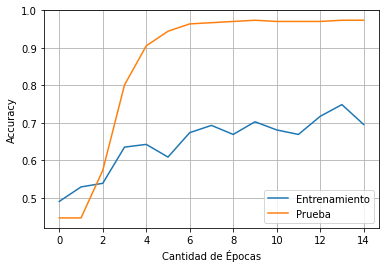

In [241]:
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

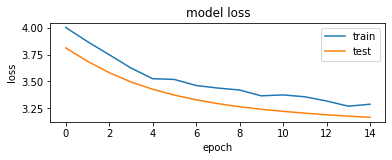

In [242]:
plt.subplot(2,1,2)
plt.plot(Historia.history['loss'])
plt.plot(Historia.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

Se puede guardar el modelo utilizando el siguiente método:

In [50]:
Red_Neuronal.save('Modelo_Satelital.h5')

Se puede usar el siguiente comando para cargar un modelo:

In [51]:
Red_Neuronal = keras.models.load_model('Modelo_Satelital.h5')

## Acceso a capas ocultas

Puedo acceder a las capas de los modelos de redes neuronales y visualizar cada salida utilizando el atributo ".layers"

Almaceno las salidas de las capas en una lista para poder visualizarlas.

In [243]:
capas_salida = [capa.output for capa in Red_Neuronal.layers]

Puedo crear un modelo auxiliar que tenga como entrada la misma que la del modelo original, y como salida las capas para el análisis.

In [244]:
Modelo_Salidas = keras.Model(inputs = Red_Neuronal.input, outputs = capas_salida)

In [245]:
Xte = X_train[0:3, :, :, :]

Hago una predicción utilizando este modelo auxiliar.

In [246]:
Salidas = Modelo_Salidas.predict(Xte)

Visualizo las capas imprimiendo con matplotlib

In [247]:
primera_capa = Salidas[0]
segunda_capa = Salidas[1]
tercera_capa = Salidas[2]

In [248]:
primera_capa[1, :, :, 0].shape

(50, 50)

In [249]:
segunda_capa[1, :, :, 0].shape

(48, 48)

In [250]:
tercera_capa[1, :, :, 0].shape

(48, 48)

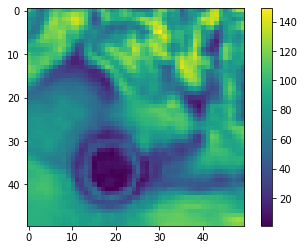

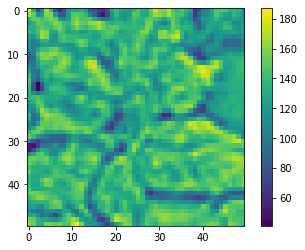

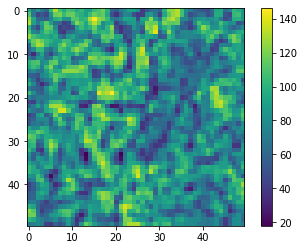

In [251]:
for i in np.arange(0, 3):
    plt.imshow((primera_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

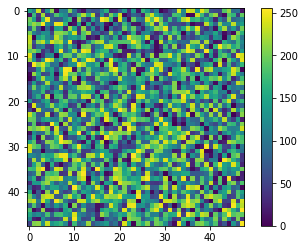

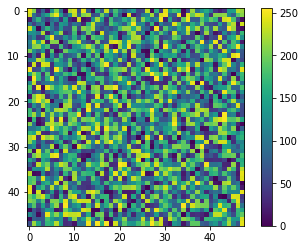

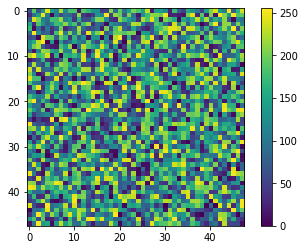

In [252]:
for i in np.arange(0, 3):
    plt.imshow((segunda_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

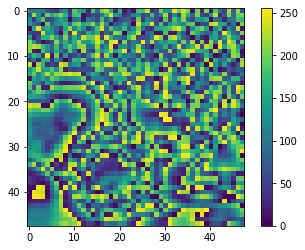

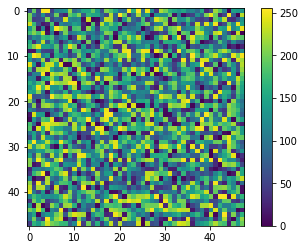

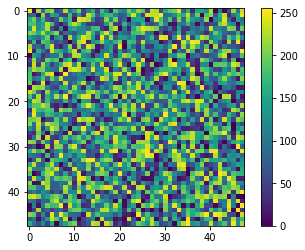

In [253]:
for i in np.arange(0, 3):
    plt.imshow((tercera_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

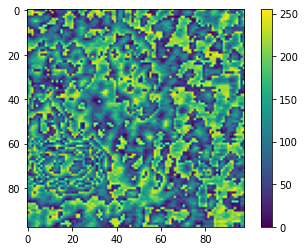

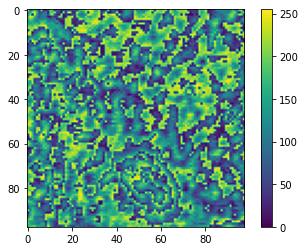

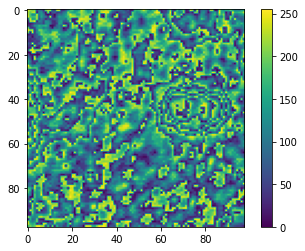

In [106]:
for i in np.arange(0, 3):
    plt.imshow((tercera_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()